### Content-based Filtering Recommendation

In [756]:
import pandas as pd
import numpy as np
import ast
import re
import random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [757]:
restaurants_data = pd.read_csv('Project Datasets/restaurants_final.csv')
restaurants_data.drop('Unnamed: 0', axis=1, inplace=True) ## remove after data correction
pd.set_option('display.max_columns', None)
restaurants_data.head(3)

,business_id,city,postal_code,categories,yelp_rating,name,RestaurantsTakeOut,BusinessAcceptsCreditCards,RestaurantsDelivery,price_level,RestaurantsReservations,HasTV,OutdoorSeating,RestaurantsGoodForGroups,WiFi,GoodForKids,BikeParking,RestaurantsAttire,Caters,BusinessParking,NoiseLevel,Ambience,GoodForMeal,RestaurantsTableService,WheelchairAccessible,HappyHour,Alcohol,DogsAllowed,BusinessAcceptsBitcoin,BYOB,Corkage,DriveThru,BestNights,CoatCheck,ByAppointmentOnly,GoodForDancing,Smoking,BYOBCorkage,Music,AgesAllowed,RestaurantsCounterService,Open24Hours,AcceptsInsurance,DietaryRestrictions,dist_highway,adjusted_gross_income,rural_urban_continuum_code_2023,unemployment_rate_2023,price_range,google_rating,user_rating_count,number_of_photos,types,dine_in,serves_breakfast,serves_lunch,serves_dinner,serves_brunch,serves_beer,serves_wine,serves_cocktails,serves_dessert,serves_coffee,editorial_summary,good_for_watching_sports,menu_for_children,parking_options,editorial_summary_language
0,--epgcb7xHGuJ-4PUeSLAw,Willow Grove,19090,"Restaurants, Food, Bagels, Sandwiches, Breakfast & Brunch",3.0,Manhattan Bagel,True,True,True,1.0,False,NaN,False,False,NaN,False,True,NaN,NaN,lot,NaN,NaN,['breakfast'],NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,allages,NaN,NaN,NaN,NaN,1.322643,713838.0,1.0,2.8,"{'startPrice': {'currencyCode': 'USD', 'units': '1'}, 'endPrice': {'currencyCode': 'USD', 'units': '10'}}",4.2,404.0,10.0,"bagel_shop, bakery, breakfast_restaurant, cafe, food_store, store, restaurant, food, point_of_interest, establishment",True,True,False,False,False,False,False,False,False,True,"Counter-serve chain specializing in NYC-style bagels & coffee, plus salads, soups & sandwiches.",False,False,"['freeParkingLot', 'freeStreetParking']",en
1,-0FX23yAacC4bbLaGPvyxw,Newtown,18940,"American (Traditional), Restaurants",3.5,The Grey Stone Fine Food and Spirits,True,True,True,3.0,True,True,True,True,free,True,NaN,NaN,True,"lot, valet",average,classy,"['dinner', 'dessert', 'lunch']",True,True,False,full_bar,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,6.546162,3633871.0,1.0,3.0,NaN,4.5,937.0,10.0,"american_restaurant, restaurant, food, point_of_interest, establishment",True,False,True,True,False,True,True,True,True,True,NaN,False,True,"['freeParkingLot', 'freeStreetParking', 'valetParking']",NaN
2,-0TffRSXXIlBYVbb5AwfTg,Philadelphia,19107,"Cocktail Bars, Food Delivery Services, Nightlife, Breakfast & Brunch, Food, Bars, Event Planning & Services, Caterers, Restaurants, Indian",4.5,IndeBlue Modern Indian Food & Spirits,True,True,True,2.0,True,False,True,True,free,True,True,casual,True,"garage, street, validated",average,classy,"['dinner', 'lunch', 'brunch']",True,NaN,True,full_bar,False,NaN,False,False,NaN,"tuesday, friday, saturday",True,False,False,no,NaN,False,NaN,NaN,NaN,NaN,NaN,0.637509,620248.0,1.0,4.2,NaN,4.5,1751.0,10.0,"indian_restaurant, brunch_restaurant, catering_service, meal_takeaway, meal_delivery, food_delivery, fine_dining_restaurant, asian_restaurant, restaurant, food, point_of_interest, establishment",True,False,True,True,True,False,True,False,True,True,"Modern & traditional Indian fare plus a tasting menu, vegetarian eats & brunch served in sleek digs.",False,False,"['freeParkingLot', 'freeStreetParking', 'no freeGarageParking']",en


#### TF-IDF Restaurant Dataset 

##### Create full description column 

In [ ]:
def convert_list_str(text):
    if pd.isna(text) or text == []:  # Handle empty lists or NaN
        return ""
    if isinstance(text, np.ndarray):  # Convert numpy array to list first
        text = text.tolist()
    if isinstance(text, list):  # Handle lists (including converted numpy arrays)
        return ' '.join(map(str, text))
    if isinstance(text, str):  # Handle string representations of lists
        try:
            items = ast.literal_eval(text)
            if isinstance(items, list):
                return ' '.join(map(str, items))
            return str(items)
        except (ValueError, SyntaxError):
            return text   
    return str(text)  # Fallback for other types

def create_full_description(df, text_features, list_features):
    # Fill missing values
    features = text_features + list_features
    df[features] = df[features].fillna('')
    
    # Fill missing editorial_summary with types + categories (without commas)
    df['editorial_summary'] = df['editorial_summary'].apply(lambda x: x if x.strip() != '' else '')
    # df['types'] = df['types'].str.replace(',', ' ')
    df['categories'] = df['categories'].str.replace(',', ' ')
    df.loc[df['editorial_summary'].str.strip() == '', 'editorial_summary'] = (
        df['categories']
    )
    df['Music'] = df['Music'].str.replace('False', '')
    df['Music'] = df['Music'].str.replace('True', '')
    
    # Convert list-formatted column to plain text
    for col in list_features:
        df[col] = df[col].apply(convert_list_str)

    # Remove commas from all text features
    for col in features:
        df[col] = df[col].str.replace(',', ' ')
    
    # if len(bool_features) != 0:
    #     # Convert boolean columns to descriptive tags
    #     for col in bool_features:
    #         df[col] = df[col].apply(lambda x: f"{col.lower()}" if x == True else "")
        
    # Combine all into a single description column
    df['description'] = df[features]\
        .agg(' '.join, axis=1)\
        .str.replace(r'\s+', ' ', regex=True)\
        .str.strip()

    return df


In [759]:
item_df = restaurants_data.copy() 
# text_features = ['categories', 'editorial_summary', 'types', 'city']
text_features = ['categories', 'editorial_summary',
                 'RestaurantsAttire', 'Ambience', 
                 'NoiseLevel', 'Music', 'city']

list_features = ['GoodForMeal', 'BusinessParking']

item_df = create_full_description(item_df, text_features, list_features)
pd.set_option('display.max_colwidth', None)
item_df[['business_id', 'description']].head(5)

,business_id,description
0,--epgcb7xHGuJ-4PUeSLAw,Restaurants Food Bagels Sandwiches Breakfast & Brunch Counter-serve chain specializing in NYC-style bagels & coffee plus salads soups & sandwiches. Willow Grove breakfast lot
1,-0FX23yAacC4bbLaGPvyxw,American (Traditional) Restaurants American (Traditional) Restaurants classy average Newtown dinner dessert lunch lot valet
2,-0TffRSXXIlBYVbb5AwfTg,Cocktail Bars Food Delivery Services Nightlife Breakfast & Brunch Food Bars Event Planning & Services Caterers Restaurants Indian Modern & traditional Indian fare plus a tasting menu vegetarian eats & brunch served in sleek digs. casual classy average Philadelphia dinner lunch brunch garage street validated
3,-1B9pP_CrRBJYPICE5WbRA,Asian Fusion Restaurants American (New) Thai Szechuan Chinese Noodles fried rice & other classic Asian mains offered in a streamlined restaurant with a bar. casual trendy classy average Philadelphia lunch dinner street
4,-3725FZiIIYdwQtM4MKEIA,Pizza Sandwiches Chicken Wings Restaurants Delivery/carryout chain offering a wide range of pizzas & a variety of other dishes & sides. casual average Glen Mills


In [760]:
print(item_df['description'].iloc[0])

Restaurants Food Bagels Sandwiches Breakfast & Brunch Counter-serve chain specializing in NYC-style bagels & coffee plus salads soups & sandwiches. Willow Grove breakfast lot


In [761]:
def process_text(text):
    text_lower = text.lower()
    tokens = word_tokenize(text_lower)
    alphabetic_tokens = [word for word in tokens if re.match('^[a-zA-Z]+$', word)]
    stop_words = set(stopwords.words('english'))
    negation_words = ['not', 'no', 'never', "n't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
                      "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "cannot"]
    tokens_no_stopwords = [word for word in alphabetic_tokens if ((word not in stop_words) or (word in negation_words))]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]
    processed_text = ' '.join(lemmatized_words)

    return processed_text

In [762]:
tfidf_vectorizer = TfidfVectorizer()
item_df['description'] = item_df['description'].apply(lambda x: process_text(x))
tfidf_scores = tfidf_vectorizer.fit_transform(item_df['description'])
print('tf-idf shape:', tfidf_scores.shape)

tf-idf shape: (8069, 2619)


In [763]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

# --- Define your features ---
bool_features = [
    'RestaurantsTakeOut', 'RestaurantsDelivery', 'RestaurantsReservations', 'OutdoorSeating',
    'RestaurantsGoodForGroups', 'GoodForKids', 'DogsAllowed', 'dine_in', 'serves_beer', 'serves_wine', 
    'serves_cocktails', 'good_for_watching_sports', 'serves_coffee', 'menu_for_children', 
    'BusinessAcceptsCreditCards', 'HasTV', 'BikeParking', 'Caters', 'RestaurantsTableService', 
    'WheelchairAccessible', 'HappyHour', 'BusinessAcceptsBitcoin'
]

num_features = [
    'yelp_rating', 'number_of_photos', 'dist_highway', 
    'rural_urban_continuum_code_2023', 'adjusted_gross_income', 
    'unemployment_rate_2023', 'user_rating_count', 
    'google_rating', 'price_level'
]

# Fill NaN with False (assume feature is false if unknown), then convert to int
bool_matrix = item_df[bool_features].fillna(False).astype(int)

# Fill NaN with column mean
item_df[num_features] = item_df[num_features].fillna(
    item_df[num_features].mean())

scaler = StandardScaler()
num_matrix = scaler.fit_transform(item_df[num_features])

combined_matrix = hstack([
    tfidf_scores,   
    csr_matrix(bool_matrix),
    csr_matrix(num_matrix)
])

print(combined_matrix)

  (0, 1901)	0.0563016130829797
  (0, 906)	0.10627416315601869
  (0, 131)	0.570746913892091
  (0, 1981)	0.28030512303205596
  (0, 257)	0.24079388883213435
  (0, 283)	0.12843700129953328
  (0, 382)	0.14897604195650788
  (0, 2169)	0.30407312761725497
  (0, 468)	0.18295190212819273
  (0, 1752)	0.17599069843898968
  (0, 1967)	0.19492293637023764
  (0, 2141)	0.25036385278966583
  (0, 2574)	0.3277610505612722
  (0, 1035)	0.3277610505612722
  (0, 1357)	0.11002315124731356
  (0, 2619)	1.0
  (0, 2620)	1.0
  (0, 2626)	1.0
  (0, 2631)	1.0
  (0, 2633)	1.0
  (0, 2635)	1.0
  (0, 2641)	-0.6894747347600346
  (0, 2642)	0.20615446916669367
  (0, 2643)	-0.43169710708158376
  (0, 2644)	-0.1409456465705877
  :	:
  (8067, 2646)	-1.0649106113725668
  (8067, 2647)	-0.30409613492985765
  (8067, 2648)	-1.8161694111924376
  (8068, 1901)	0.16229545300358209
  (8068, 122)	0.14451617507971717
  (8068, 665)	0.10364554369588917
  (8068, 1364)	0.1002798765794147
  (8068, 361)	0.10862482237216207
  (8068, 1553)	0.431955

C:\Users\user\AppData\Local\Temp\ipykernel_23068\609312191.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bool_matrix = item_df[bool_features].fillna(False).astype(int)


#### Construct user-restaurant interaction data
Binarized rating >=3 as 1 and else 0 as we assume users had positive interaction with restauratns that rated greater than 3 and had negative interaction with restaurants raterd less than 4. 

In [764]:
review_data = pd.read_csv('Project Datasets/review_final.csv')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')
review_data.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0,2369,0.712890,2.138669
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2,3649,0.593757,2.968783


In [765]:
# user_cluster_df = pd.read_csv('user_cluster.csv')
# user_cluster_df.head(2)

In [816]:
review_df = review_data.copy() 
# review_df = review_data.merge(user_cluster_df, on='user_id', how='left')
review_df['interaction'] = review_df['stars'].apply(lambda x: 1 if x>=3 else 0)
# interaction_df = review_df[['user_id', 'business_id', 'stars', 'interaction', 'date', 'cluster']]
interaction_df = review_df[['user_id', 'business_id',
                            'stars', 'interaction', 'date']]
interaction_df.head(2)

,user_id,business_id,stars,interaction,date
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,1,2018-07-07 22:09:11
1,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,2015-01-04 00:01:03


#### Construct content-based filtering model 
- cold-start management: recommend restauratns based on their cluster popularity if the user has 1 interaction (too few)
- Recommend restaurants based on histroical interactions. Give more weights on the user's rating on the restauratns

In [817]:
# Leave-one-out train-test split 
# interaction_df['rank_latest'] = interaction_df.groupby('user_id')['date'].rank(method='first', ascending=False)
train_df = interaction_df[interaction_df['date'] < '2021-01-01']
test_df = interaction_df[interaction_df['date'] >= '2021-01-01']

In [818]:
print('train set size:', len(train_df))
print('test set size:', len(test_df))

train set size: 765907
test set size: 70772


In [819]:
# def get_popular_restaurants_by_cluster(cluster, k = 10):
#     cluster_interaction = interaction_df.loc[interaction_df['cluster']==cluster]
#     appearance_count = cluster_interaction['business_id'].value_counts().rename('count')
#     cluster_interaction = cluster_interaction.merge(appearance_count, left_on='business_id', right_index=True)
#     cluster_based_restaurants = cluster_interaction.sort_values(['stars', 'count', 'date'], ascending=[False, False, False])['business_id']
#     popular_restaurants = []
#     seen = set()

#     for business_id in cluster_based_restaurants:
#         if business_id not in seen:
#             seen.add(business_id)
#             popular_restaurants.append(business_id)
#         if len(popular_restaurants) == k:
#             break

#     return popular_restaurants


In [820]:
# def get_content_recommendation(user_id, k = 10):
#     # Look for past interacted restaurants
#     # If user has only one interacted past restaurant, recommend based on poular items in their user's cluster
#     # If user has multiple interacted restaurants, recommend based on content filtering 
#     past_restaurants = train_df.loc[(train_df['user_id']==user_id) & (interaction_df['interaction']==1)]
#     if past_restaurants.empty:
#         user_cluster = interaction_df.loc[interaction_df['user_id']==user_id]['cluster'].iloc[0]
#         return get_popular_restaurants_by_cluster(user_cluster, k)
    
#     restaurants_ids = past_restaurants['business_id'].tolist()
#     restaurants_indices = item_df[item_df['business_id'].isin(restaurants_ids)].index.tolist()
#     query_embedding = np.asarray(tfidf_scores[restaurants_indices].mean(axis=0)).reshape(1, -1)

#     # Step 2 
#     similarity_scores = cosine_similarity(query_embedding, tfidf_scores)

#     # Step 3 
#     similarity_scores[similarity_scores >= 0.99] = 0

#     # Step 4 
#     top_10_indices = np.argsort(similarity_scores.flatten())[::-1][:k]
#     recommended_restaurants_ids = item_df.iloc[top_10_indices]['business_id']
#     return recommended_restaurants_ids

In [ ]:
# Added weights based on actual rating --> if higher actual rating, give more weight  
def get_content_recommendation(user_id, k=10, visualize=True):
    # past_restaurants = train_df.loc[(train_df['user_id'] == user_id) & (train_df['interaction'] == 1)]
    past_restaurants = train_df.loc[(train_df['user_id'] == user_id)] # this change allows learning of "dislikes"

    if past_restaurants.empty:
        return pd.DataFrame(columns=['business_id', 'similarity_score']) # No recommendations

    restaurant_indices = []
    aligned_ratings = []

    for _, row in past_restaurants.iterrows():
        business_id = row['business_id']
        rating = row['stars']
        idx = item_df[item_df['business_id'] == business_id].index
        if len(idx) > 0:
            restaurant_indices.append(idx[0])
            aligned_ratings.append(rating)

    vectors = combined_matrix[restaurant_indices].toarray()
    weights = np.array(aligned_ratings) - 3 # center ratings at neutral (3)
    weights = weights.reshape(-1, 1)

    weighted_embedding = (vectors * weights).sum(axis=0)
    query_embedding = weighted_embedding.reshape(1, -1)

    similarity_scores = cosine_similarity(
        query_embedding, combined_matrix).flatten()
    
    ## Removed to allow previously interacted restaurants to be recommended
    # already_seen_indices = item_df[item_df['business_id'].isin(past_restaurants['business_id'])].index.tolist()
    # similarity_scores[already_seen_indices] = 0 
    
    similarity_scores[similarity_scores >= 0.99] = 0

    top_k_indices = np.argsort(similarity_scores.flatten())[::-1][:k]
    top_k_scores = similarity_scores.flatten()[top_k_indices]
    recommended_ids = item_df.iloc[top_k_indices]['business_id'].values

    # Construct a DataFrame with results
    recommended_df = pd.DataFrame({
        'business_id': recommended_ids,
        'similarity_score': top_k_scores
    })

    recommended_df['similarity_score'] = recommended_df['similarity_score'].round(3)

    return recommended_df.reset_index(drop=True)

#### Evaluation - Hit@10

In [822]:
test_df.head(2)

,user_id,business_id,stars,interaction,date
42877,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1.0,0,2021-01-02 00:19:00
43178,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5.0,1,2021-01-26 18:01:45


In [823]:
def hit_rate_at_k(user_id, test_df, recommend_func, k=10):
    # true_item = test_df.loc[test_df['user_id'] == user_id]['business_id'].iloc[0]
    true_items = test_df[(test_df['user_id'] == user_id) &
                         (test_df['stars'] >= 3) # Hit rate should consider if the user liked the restaurant
                         ]['business_id'].tolist()
    recommended = recommend_func(user_id, k)

    # Handle if the function returns a list instead of DataFrame
    if isinstance(recommended, list):
        recommended_items = recommended
    else:
        recommended_items = recommended['business_id'].tolist()

    return int(any(item in recommended_items for item in true_items))

In [824]:
def get_hit_rate_for_n_users(users):
    total_hit_rate = 0
    for user in users:
        hit_rate = hit_rate_at_k(user, test_df, get_content_recommendation, k=10)
        total_hit_rate += hit_rate 
        # if hit_rate==1:
        #     print(user)
    return total_hit_rate / len(users)

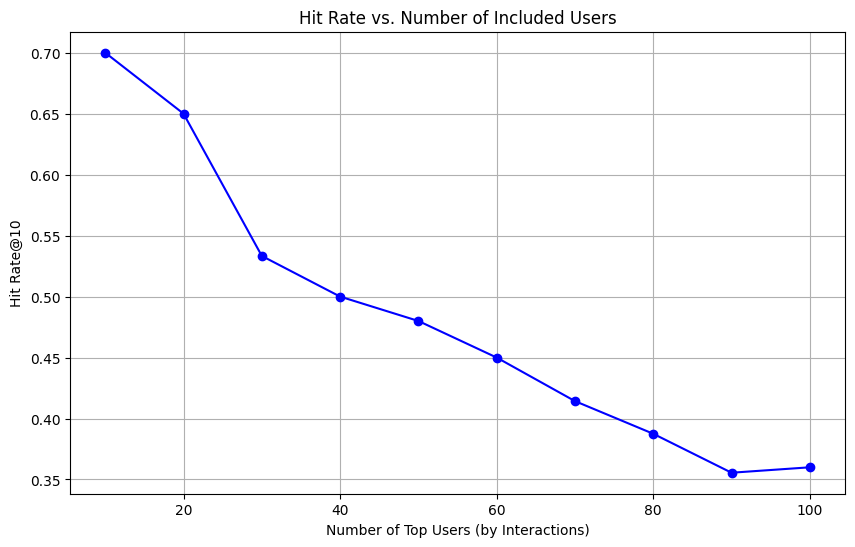

In [825]:
import numpy as np
import matplotlib.pyplot as plt
random.seed(0) 

def plot_hit_rate_vs_users(test_df, max_users, step):
    n_users_range = range(10, max_users + 1, step)
    hit_rates = []

    for n_users in n_users_range:
        # Get top n_users by interaction count 
        # (Idea: users with more interactions are likely to have higher hit rate 
        # since they are more likely to have interactions with the recommended restaurants)
        top_users = (
            test_df
            .groupby('user_id')
            .size()
            .sort_values(ascending=False)
            .head(n_users)
            .index.tolist()
        )

        # Compute hit rate for these users
        hit_rate = get_hit_rate_for_n_users(
            users=top_users,
        )
        hit_rates.append(hit_rate)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Top Users (by Interactions)")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Included Users")
    plt.grid(True)
    plt.show()
    

plot_hit_rate_vs_users(test_df, max_users=100, step=10)

In [826]:
recommendations = get_content_recommendation('mh_-eMZ6K5RLWhZyISBhwA', k=10)
features = ['business_id', 'name', 'description'] + text_features + list_features + bool_features + num_features
recommendations = recommendations.merge(
    item_df[features], on='business_id', how='left')
pd.set_option('display.max_columns', None)
recommendations

,business_id,similarity_score,name,description,categories,editorial_summary,RestaurantsAttire,Ambience,NoiseLevel,Music,city,GoodForMeal,BusinessParking,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,OutdoorSeating,RestaurantsGoodForGroups,GoodForKids,DogsAllowed,dine_in,serves_beer,serves_wine,serves_cocktails,good_for_watching_sports,serves_coffee,menu_for_children,BusinessAcceptsCreditCards,HasTV,BikeParking,Caters,RestaurantsTableService,WheelchairAccessible,HappyHour,BusinessAcceptsBitcoin,yelp_rating,number_of_photos,dist_highway,rural_urban_continuum_code_2023,adjusted_gross_income,unemployment_rate_2023,user_rating_count,google_rating,price_level
0,u50hTvPV_W_Hx625ytvLYw,0.875,Hatboro Pizza,salad food delivery service italian event planning service cheesesteaks restaurant caterer pizza food chicken wing quaint pizzeria serf traditional white pizza plus sandwich burger casual casual average hatboro lunch dinner street,Salad Food Delivery Services Italian Event Planning & Services Cheesesteaks Restaurants Caterers Pizza Food Chicken Wings,Quaint family-run pizzeria serves traditional & white pizzas plus sandwiches & burgers.,casual,casual,average,,Hatboro,lunch dinner,street,True,True,False,False,True,True,False,True,False,False,False,False,False,True,True,True,True,True,False,True,False,NaN,3.5,10.0,1.633556,1.0,877828.0,2.9,357.0,4.4,1.0
1,8n_BlTxfALO08FWdb6Tnbg,0.874,Pholosophy,restaurant vietnamese restaurant vietnamese casual average narberth dinner lunch brunch street,Restaurants Vietnamese,Restaurants Vietnamese,,casual,average,,Narberth,dinner lunch brunch,street,True,True,True,True,True,True,False,True,False,False,False,False,True,False,True,True,True,True,True,True,False,False,4.0,10.0,1.757572,1.0,1143777.0,2.8,186.0,4.5,1.0
2,AtDtwv66pG52TehGR3f6tQ,0.872,Randazzo's Pizzeria,pizza restaurant pizza restaurant casual casual average willow grove lunch dinner,Pizza Restaurants,Pizza Restaurants,casual,casual,average,,Willow Grove,lunch dinner,,True,True,False,False,True,True,False,True,False,False,False,False,False,True,True,True,True,True,True,NaN,NaN,NaN,4.0,10.0,1.322643,1.0,713838.0,2.8,344.0,4.2,1.0
3,HNREwZWJqeapl4-uRhaKNg,0.869,PrimoHoagies,sandwich restaurant italian sandwich chain known hefty hoagy built roll casual average hatboro breakfast lunch dinner brunch lot,Sandwiches Restaurants Italian,Philly-born counter-serve sandwich chain known for its hefty hoagies built on sesame-seed rolls.,casual,,average,,Hatboro,breakfast lunch dinner brunch,lot,True,True,True,False,True,True,False,True,False,False,False,False,False,False,True,True,True,True,False,True,NaN,NaN,3.5,10.0,1.633556,1.0,877828.0,2.9,300.0,4.4,1.0
4,CATqJGCwqj2YBt2yp8BXHw,0.869,Narberth Pizza Italian Delite,italian restaurant pizza italian restaurant pizza casual casual quiet narberth lunch dinner lot,Italian Restaurants Pizza,Italian Restaurants Pizza,casual,casual,quiet,,Narberth,lunch dinner,lot,True,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,True,True,NaN,NaN,NaN,NaN,3.5,10.0,1.757572,1.0,1143777.0,2.8,139.0,4.4,1.0
5,UEZHkxpJ0fKeu65Ps2oLtA,0.868,Hatboro Dish,restaurant american traditional breakfast brunch restaurant american traditional breakfast brunch casual casual average hatboro lunch brunch breakfast street,Restaurants American (Traditional) Breakfast & Brunch,Restaurants American (Traditional) Breakfast & Brunch,casual,casual,average,,Hatboro,lunch brunch breakfast,street,True,True,False,False,True,True,False,True,False,False,False,False,True,True,True,True,True,True,True,NaN,NaN,NaN,4.0,10.0,1.633556,1.0,877828.0,2.9,455.0,4.4,1.0
6,YHvJyyklyzsQhCnbJu7pFA,0.868,Nino's Pizzarama - Willow Grove,pizza italian restaurant italian eatery dishing whole red white pie plus sandwich wing casual casual average willow grove lunch dinner lot,Pizza Italian Restaurants,Family-run Italian eatery dishing up whole & by-the-slice red & white pies plus sandwiches & wings.,casual,casual,averag

#### Used for SBERT model 
- better performance on finding similar restaurants given the same user 
- hit@10 also increased by 2% 

In [827]:
# from sentence_transformers import SentenceTransformer
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# # Load SBERT model
# sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# # Apply SBERT embedding to each restaurant description
# item_df['sbert_embedding'] = item_df['description'].apply(lambda x: sbert_model.encode(x, show_progress_bar=False))

# # Create the matrix of all item embeddings
# embedding_matrix = np.vstack(item_df['sbert_embedding'].values)

In [828]:
# def get_content_recommendation(user_id, k=10):
#     past_restaurants = train_df.loc[
#         (train_df['user_id'] == user_id) & (train_df['interaction'] == 1)
#     ]

#     # Cold-start: no positive history
#     if past_restaurants.empty:
#         user_cluster = interaction_df.loc[
#             interaction_df['user_id'] == user_id
#         ]['cluster'].iloc[0]
#         return get_popular_restaurants_by_cluster(user_cluster, k)

#     # Step 1: Align ratings and SBERT embeddings
#     restaurant_indices = []
#     aligned_ratings = []

#     for _, row in past_restaurants.iterrows():
#         business_id = row['business_id']
#         rating = row['stars']

#         idx = item_df[item_df['business_id'] == business_id].index
#         if len(idx) > 0:
#             restaurant_indices.append(idx[0])
#             aligned_ratings.append(rating)

#     if len(restaurant_indices) == 0:
#         user_cluster = interaction_df.loc[
#             interaction_df['user_id'] == user_id
#         ]['cluster'].iloc[0]
#         return get_popular_restaurants_by_cluster(user_cluster, k)

#     # Step 2: Compute weighted embedding
#     vectors = embedding_matrix[restaurant_indices]                      # shape: (N, 384)
#     weights = np.array(aligned_ratings).reshape(-1, 1)                  # shape: (N, 1)

#     weighted_embedding = (vectors * weights).sum(axis=0) / weights.sum()
#     query_embedding = weighted_embedding.reshape(1, -1)

#     # Step 3: Compute cosine similarity
#     similarity_scores = cosine_similarity(query_embedding, embedding_matrix)

#     # Step 4: Remove already-seen restaurants
#     already_seen_indices = item_df[item_df['business_id'].isin(
#         past_restaurants['business_id']
#     )].index.tolist()
#     similarity_scores[:, already_seen_indices] = 0
#     similarity_scores[similarity_scores >= 0.99] = 0  # avoid near duplicates

#     # Step 5: Get top-k recommendations
#     top_k_indices = np.argsort(similarity_scores.flatten())[::-1][:k]

#     # Step 6: Return business_ids with similarity scores
#     recommended_items = item_df.iloc[top_k_indices][['business_id']].copy()
#     recommended_items['similarity_score'] = similarity_scores[0, top_k_indices]
#     recommended_items['similarity_score'] = recommended_items['similarity_score'].round(3)

#     return recommended_items.reset_index(drop=True)


In [829]:
# random.seed(0) 
# n_users = 50
# random_user_ids = random.sample(user_ids, n_users)
# print(f'Average hit rate: ', get_hit_rate_for_n_users(random_user_ids))

In [830]:
# random.seed(0) 
# n_users = 50
# pos_random_user_ids = random.sample(pos_user_ids, n_users)
# print(f'Average hit rate: ', get_hit_rate_for_n_users(pos_random_user_ids))